<a href="https://colab.research.google.com/github/chetansolanke14/DeepLeaening_Project/blob/master/BehaviourCloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
!git clone https://github.com/chetansolanke14/Track1.git

fatal: destination path 'Track1' already exists and is not an empty directory.


In [77]:
!ls Track1/Data

driving_log.csv  IMG


In [78]:
!pip3 install imgaug

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random
%matplotlib inline

In [304]:
datadir = 'Track1/Data'
columns = ['center','left','right','steering','throttle','reverse','speed']
data=pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)

pd.set_option('display.max_colwidth', -1)
data.head(5)

center  ...     speed
0  /Users/chetu/ml/projects/autonomouscar/IMG/center_2019_05_14_22_54_04_336.jpg  ...  20.37984
1  /Users/chetu/ml/projects/autonomouscar/IMG/center_2019_05_14_22_54_04_407.jpg  ...  20.21600
2  /Users/chetu/ml/projects/autonomouscar/IMG/center_2019_05_14_22_54_04_480.jpg  ...  20.05347
3  /Users/chetu/ml/projects/autonomouscar/IMG/center_2019_05_14_22_54_04_550.jpg  ...  19.93244
4  /Users/chetu/ml/projects/autonomouscar/IMG/center_2019_05_14_22_54_04_623.jpg  ...  19.77219

[5 rows x 7 columns]

In [305]:
#Remove tail end of the path "right, left, centere" columns as image has C drive path in it : ntpath library is used

def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2019_05_14_22_54_04_336.jpg  ...  20.37984
1  center_2019_05_14_22_54_04_407.jpg  ...  20.21600
2  center_2019_05_14_22_54_04_480.jpg  ...  20.05347
3  center_2019_05_14_22_54_04_550.jpg  ...  19.93244
4  center_2019_05_14_22_54_04_623.jpg  ...  19.77219

[5 rows x 7 columns]

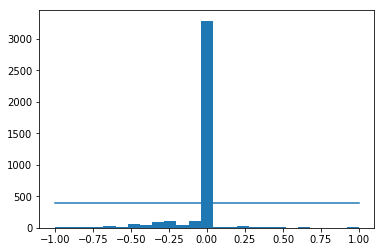

In [306]:
#Plot steering angle on a histogram in order to visualize the distribution and see what steering angles
#are most frequent, to verify flaws in data 
num_bins=25
samples_per_bin=400
hist,bins=np.histogram(data['steering'],num_bins)
center =(bins[:-1]+bins[1:])* 0.5 #stering values are not centeered around 0, hence will do that ie elementwise addition
#print(bins)


plt.bar(center,hist,width=0.08)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

#Visualization:
#Most of the time steering is 0.0 as we are driving on the straight track and in the moddle of the road
#hence left and right is balanced


In [0]:
from sklearn.utils import shuffle

total data: 3931
removed: 2887
remaining: 1044


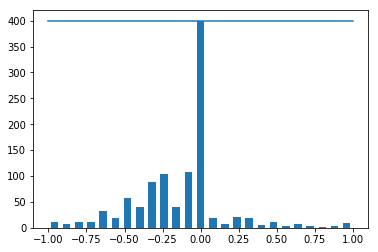

In [308]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  listtmp_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      listtmp_.append(i)
  listtmp_ = shuffle(listtmp_)
  listtmp_ = listtmp_[samples_per_bin:]
  remove_list.extend(listtmp_)

  
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [309]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2019_05_14_22_54_05_052.jpg
left        left_2019_05_14_22_54_05_052.jpg  
right       right_2019_05_14_22_54_05_052.jpg 
steering   -0.15                              
throttle    0                                 
reverse     0                                 
speed       18.9438                           
Name: 10, dtype: object


In [310]:
steerings

array([ 0.  ,  0.15, -0.15, ...,  0.  ,  0.15, -0.15])

In [311]:
X_train,X_valid,y_train,y_valid =train_test_split(image_paths, steerings, test_size=0.2,random_state=6)
print("Training samples: {}\n Valid Samples: {}".format(len(X_train),len(X_valid)))

Training samples: 2505
 Valid Samples: 627


Text(0.5, 1.0, 'Validation set')

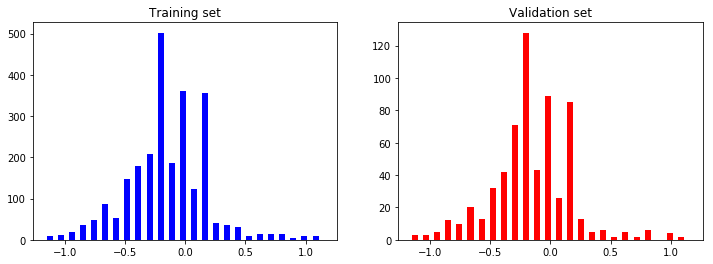

In [312]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [0]:
def zoom(image):
  zoom=iaa.Affine(scale=(1,1.3))
  image=zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'zoomed_image')

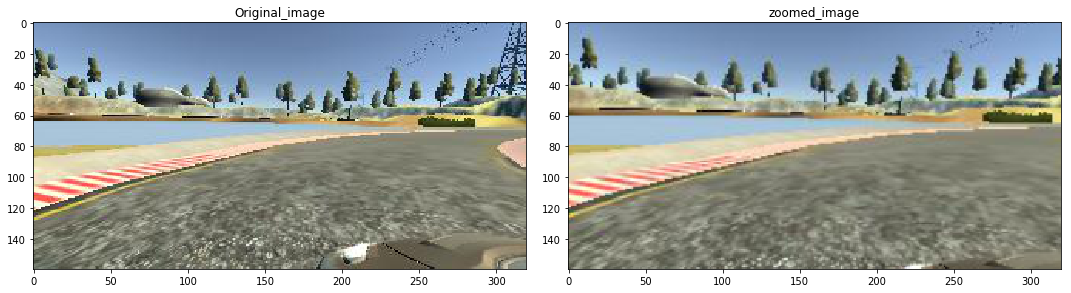

In [314]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
zoomed_image=zoom(original_image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original_image')
axs[1].imshow(zoomed_image)
axs[1].set_title('zoomed_image')

In [0]:
#image panning
def pan(image):
  pan=iaa.Affine(translate_percent={'x': (-0.1,0.1), 'y':(-0.1,0.1)}) #select rndom percentof pan
  image=pan.augment_image(image)
  return image

Text(0.5, 1.0, 'panned image')

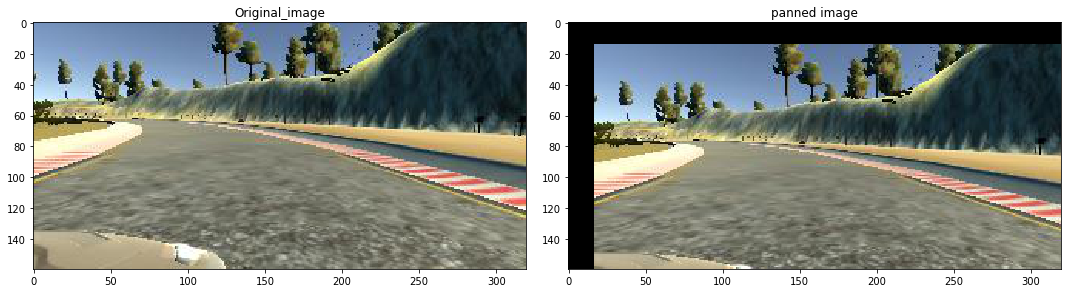

In [316]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
panned_image=pan(original_image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original_image')
axs[1].imshow(panned_image)
axs[1].set_title('panned image')

In [0]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness altered image')

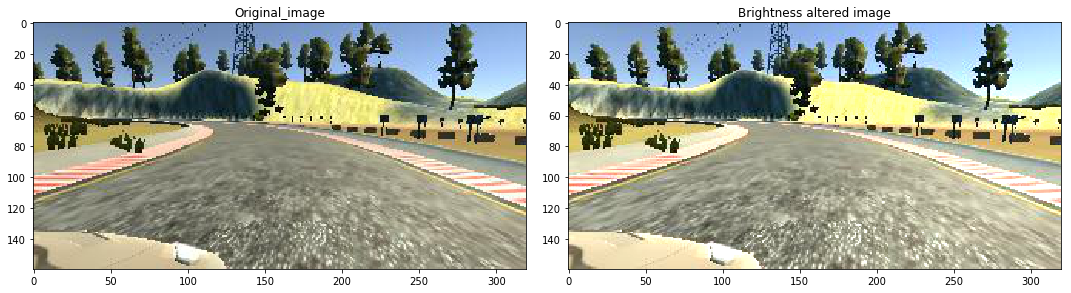

In [318]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
brightness_altered_image=img_random_brightness(original_image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original_image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image')

In [0]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.2')

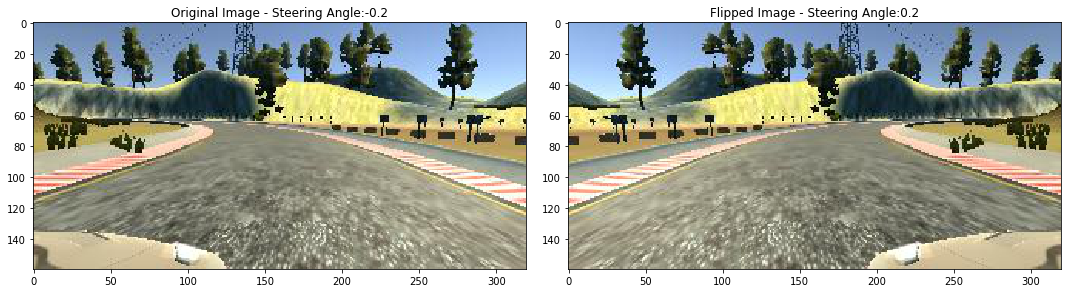

In [320]:
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [0]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

In [322]:
steerings

array([ 0.  ,  0.15, -0.15, ...,  0.  ,  0.15, -0.15])

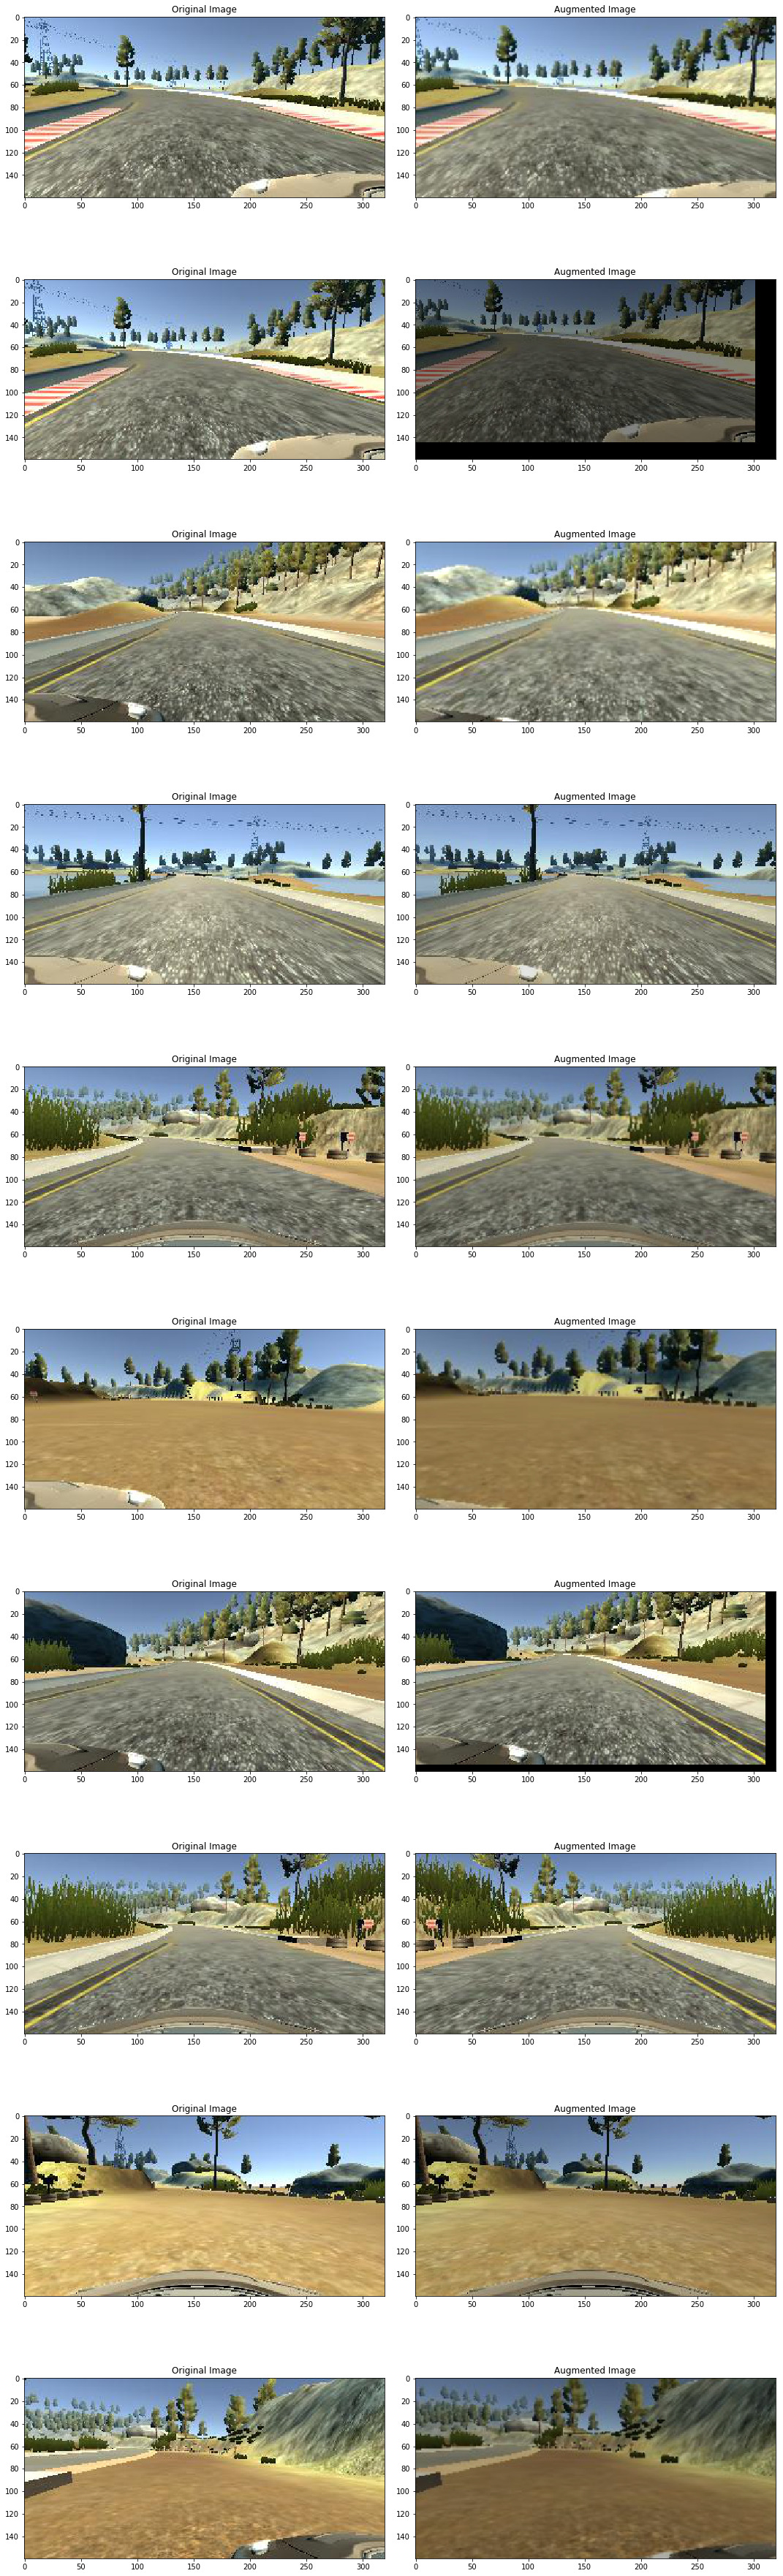

In [323]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [0]:
#Preprocessing Images

def img_preprocess(img):
  #img= mpimg.imread(img)
  img= img[60:135,:,:]
  img=cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  #Add gaussian blur
  img=cv2.GaussianBlur(img, (3,3), 0)
  img=cv2.resize(img,(200,66))
  img=img/255
  return img

In [325]:
image_paths[100]

'Track1/Data/IMG/left_2019_05_14_22_54_17_142.jpg'

Text(0.5, 1.0, 'preprocessed_image')

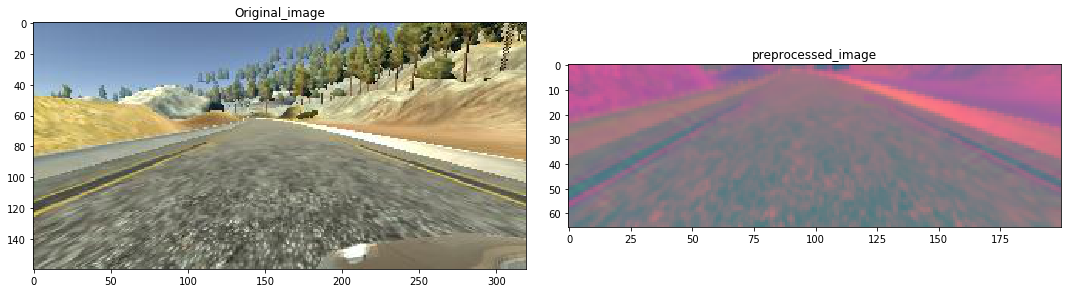

In [326]:
image =image_paths[10]
original_image = mpimg.imread(image)
preprocessed_image =img_preprocess(original_image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original_image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('preprocessed_image')

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  

(1, 66, 200, 3)


Text(0.5, 1.0, 'Validation Image')

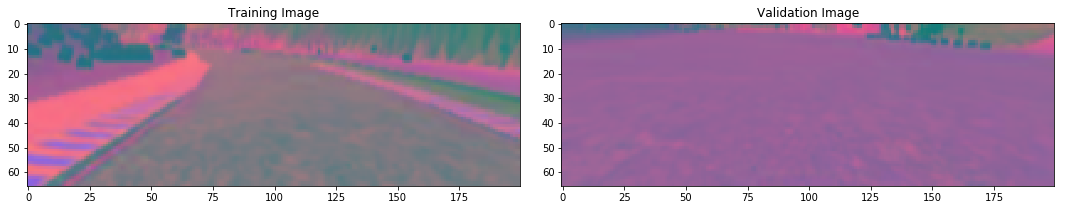

In [328]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
print(x_train_gen.shape)
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [0]:
#X_train=np.array(list(map(img_preprocess,X_train)))
#X_valid=np.array(list(map(img_preprocess,X_valid)))
#A= list[[map(img_preprocess,X_train)]]

In [0]:
#plt.imshow(X_train[random.randint(0,len(X_train)-1)])
#plt.axis("off")
#print(X_train.shape)

In [0]:
#Nvidia Model
#Appropriate steering angle:
#Model Used for BEhaviour Training,
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  
  model.add(Convolution2D(64, 3, 3, activation='elu'))
#   model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))
 
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [330]:
model = nvidia_model()

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)               115300    
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

In [267]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               115300    
__________

In [331]:
#model trainig Process

#history= model.fit(X_train,y_train, epochs=30, validation_data=(X_valid,y_valid), batch_size=100, verbose=1, shuffle=1)

history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 142s 474ms/step - loss: 0.1337 - val_loss: 0.0893
Epoch 2/10
300/300 [==============================] - 131s 436ms/step - loss: 0.0935 - val_loss: 0.0742
Epoch 3/10
300/300 [==============================] - 131s 436ms/step - loss: 0.0806 - val_loss: 0.0667
Epoch 4/10
300/300 [==============================] - 131s 435ms/step - loss: 0.0758 - val_loss: 0.0628
Epoch 5/10
300/300 [==============================] - 132s 441ms/step - loss: 0.0715 - val_loss: 0.0617
Epoch 6/10
300/300 [==============================] - 132s 440ms/step - loss: 0.0659 - val_loss: 0.0634
Epoch 7/10
300/300 [==============================] - 134s 447ms/step - loss: 0.0647 - val_loss: 0.0565
Epoch 8/10
300/300 [==============================] - 133s 442ms/step - loss: 0.0603 - val_loss: 0.0613
Epoch 9/10
300/300 [==============================] - 133s 445ms/step - loss: 0.0579 - val_loss: 0.0557
Epoch 10/10
300/300 [==============================] - 133s 444m

Text(0.5, 0, 'Epoch')

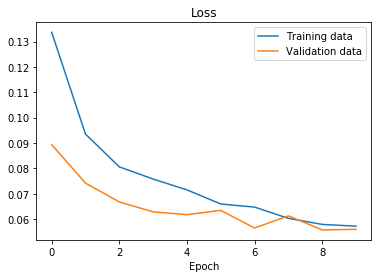

In [332]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Training data","Validation data"])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
#relu can cause dead relu henceuse elu (leaky relu)
#eliminate overfitting add dropout layer


In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')